# Observe reconstruction fidelity

In [40]:
import VAE_tybalt
from VAE_tybalt import VAE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torchvision
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import random
from random import sample
import seaborn as sns

In [41]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [42]:
model.load_state_dict(torch.load('vae_weights.pth'))

<All keys matched successfully>

Load data

In [48]:
tcga_tybalt_file_location = 'data/rnaseq_df_test.csv'
rnaseq_df = pd.read_csv(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1,  inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [49]:
rnaseq_df

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.000000,0.711395,0.079027,0.000000,0.000000,0.023197,0.121969,0.062543,0.000000,0.000000,...,0.572671,0.512329,0.461674,0.491376,0.501528,0.495456,0.644358,0.113569,0.429427,0.582995
1,0.781910,0.031101,0.684937,0.700038,0.230084,0.254548,0.416508,0.361120,0.781960,0.786848,...,0.659345,0.208477,0.458558,0.505048,0.454214,0.501694,0.586376,0.263308,0.332541,0.388225
2,0.788988,0.079403,0.457493,0.680465,0.366980,0.285862,0.310623,0.352631,0.769542,0.737494,...,0.293865,0.247636,0.407056,0.375633,0.160404,0.778409,0.753785,0.043088,0.535991,0.555555
3,0.747995,0.046092,0.130644,0.177930,0.129670,0.115420,0.039233,0.157857,0.729496,0.689956,...,0.479202,0.082720,0.480683,0.638266,0.464715,0.302999,0.599158,0.169778,0.289458,0.360866
4,0.000000,0.798650,0.712625,0.560407,0.061522,0.166504,0.664300,0.331431,0.000000,0.000000,...,0.799483,0.487555,0.380651,0.409978,0.531780,0.534171,0.609271,0.146475,0.193681,0.412169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,0.736170,0.152171,0.476311,0.702972,0.768507,0.343426,0.281088,0.758171,0.760010,0.740522,...,0.728246,0.450068,0.435667,0.488870,0.465533,0.509826,0.706824,0.165557,0.337093,0.427780
2088,0.038897,0.759848,0.311547,0.646421,0.384474,0.253147,0.215385,0.431012,0.077446,0.045757,...,0.654467,0.365170,0.405802,0.517247,0.563040,0.391213,0.665276,0.427613,0.196777,0.596736
2089,0.530575,0.151500,0.332931,0.694337,0.931342,0.262074,0.335299,0.671591,0.751476,0.763546,...,0.367071,0.262613,0.361214,0.661306,0.897802,0.482602,0.739770,0.044569,0.468041,0.341742
2090,0.764453,0.174147,0.824906,0.453406,0.608007,0.842768,0.765355,0.648007,0.779927,0.729218,...,0.478843,0.438191,0.567193,0.274560,0.363217,0.512191,0.693135,0.110666,0.242758,0.675748


In [51]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor = model.forward(torch.tensor(rnaseq_df.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct_tensor.detach().numpy(), columns=rnaseq_df.columns)

In [52]:
input_rnaseq_reconstruct.head()

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.392196,0.440363,0.090991,0.040509,0.016955,0.029073,0.066859,0.029446,0.434584,0.393305,...,0.601779,0.431708,0.434780,0.475596,0.472392,0.392186,0.559506,0.126659,0.386973,0.530485
1,0.642369,0.161431,0.599108,0.630581,0.249375,0.267362,0.383985,0.368260,0.605991,0.603992,...,0.662478,0.280174,0.485396,0.579159,0.446489,0.362869,0.577764,0.088252,0.430419,0.438792
2,0.592437,0.158753,0.557585,0.598480,0.419911,0.353898,0.344681,0.429799,0.607325,0.555333,...,0.341814,0.166916,0.517873,0.426606,0.227625,0.699585,0.776097,0.017754,0.446049,0.420420
3,0.531072,0.299083,0.156825,0.101268,0.048222,0.082825,0.111131,0.069976,0.503344,0.436715,...,0.472719,0.425337,0.521296,0.590123,0.511961,0.382089,0.611232,0.181689,0.398892,0.518445
4,0.014901,0.823157,0.649779,0.628396,0.170455,0.154533,0.604689,0.365582,0.008554,0.006358,...,0.669659,0.580147,0.406847,0.512645,0.566429,0.436703,0.563815,0.100281,0.240605,0.394744


In [53]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
PPAN-P2RY11,0.008488,0.245845
DDX3Y,0.009494,0.223767
GSTT1,-0.027096,0.221800
GSTM1,-0.003299,0.221668
EIF1AY,0.011315,0.221310


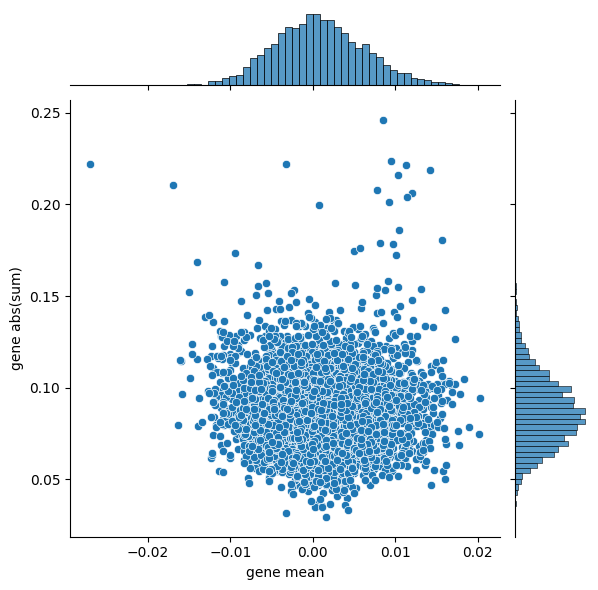

In [54]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

Compute reconstruction losses

In [65]:
BCE_loss = []
KLD_loss = []
MSE_loss = []
# print row vectors next to each other in a loop
for i in range(len(rnaseq_df)):
    x = torch.Tensor(rnaseq_df.iloc[i].values)
    y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
    bce_loss = F.binary_cross_entropy(x, y)
    mse_loss = F.mse_loss(x,y)
    
    #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
    #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))
    
    #kld_loss = torch.sum(kl_divergence(x, prior).item())
    BCE_loss.append(bce_loss)
    MSE_loss.append(mse_loss)
    

Permutation and adding noise

In [72]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(df_shuffled.iloc[i, subset_cols])
    return df_shuffled


In [77]:
rnaseq_df.shape[1]

5000

In [105]:
#1 percent of data shuffeled
rnaseq_df_1 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.01))

#3.0 percent of data shuffeled
rnaseq_df_3 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.05))

#5.0 percent of data shuffeled
rnaseq_df_5 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.10))

#8.0 percent of data shuffeled
rnaseq_df_8 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.30))

#10.0 percent of data shuffeled
rnaseq_df_10 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.50))

#20.0 percent of data shuffeled
rnaseq_df_20 = shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.80))

In [106]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1 = model.forward(torch.tensor(rnaseq_df_1.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_1 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_1.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3 = model.forward(torch.tensor(rnaseq_df_3.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_3 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_3.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5 = model.forward(torch.tensor(rnaseq_df_5.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_5 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_5.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8 = model.forward(torch.tensor(rnaseq_df_8.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_8 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_8.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10 = model.forward(torch.tensor(rnaseq_df_10.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_10 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_10.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20 = model.forward(torch.tensor(rnaseq_df_20.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_20 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_20.detach().numpy(), columns=rnaseq_df.columns)

In [109]:
#compute losses
def compute_losses(rnaseq_df, input_rnaseq_reconstruct):
    BCE_loss = []
    MSE_loss = []
    KLD_loss = []
    for i in range(len(rnaseq_df)):
        x = torch.Tensor(rnaseq_df.iloc[i].values)
        y= torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
        bce_loss = F.binary_cross_entropy(x, y, reduction='sum')
        mse_loss = F.mse_loss(x,y, reduction='sum')

        #prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
        #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))

        #kld_loss = torch.sum(kl_divergence(x, prior).item())
        BCE_loss.append(bce_loss)
        MSE_loss.append(mse_loss)
        
        return np.mean(BCE_loss), np.mean(MSE_loss)

In [111]:
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20))

(5399.9487, 40.054382)
(5974.1797, 50.977036)
(6905.1753, 47.345905)
(6103.0864, 39.417805)
(6260.173, 42.88714)
(11506.313, 146.51938)


In [113]:
# Each row is shuffled identically
import pandas as pd
import numpy as np

def shuffle_same_subset_rows(df, subset_size):
    """
    Shuffles the same random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    subset_cols = np.random.choice(num_cols, subset_size, replace=False)
    for i in range(len(df_shuffled)):
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(df_shuffled.iloc[i, subset_cols])
    return df_shuffled



In [114]:
#1 percent of data shuffeled
rnaseq_df_1 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.01))

#3.0 percent of data shuffeled
rnaseq_df_3 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.05))

#5.0 percent of data shuffeled
rnaseq_df_5 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.10))

#8.0 percent of data shuffeled
rnaseq_df_8 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.30))

#10.0 percent of data shuffeled
rnaseq_df_10 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.50))

#20.0 percent of data shuffeled
rnaseq_df_20 = shuffle_same_subset_rows(rnaseq_df, int(rnaseq_df.shape[1]*0.80))

In [115]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1 = model.forward(torch.tensor(rnaseq_df_1.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_1 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_1.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3 = model.forward(torch.tensor(rnaseq_df_3.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_3 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_3.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5 = model.forward(torch.tensor(rnaseq_df_5.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_5 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_5.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8 = model.forward(torch.tensor(rnaseq_df_8.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_8 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_8.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10 = model.forward(torch.tensor(rnaseq_df_10.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_10 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_10.detach().numpy(), columns=rnaseq_df.columns)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20 = model.forward(torch.tensor(rnaseq_df_20.values, dtype=torch.float32))[0]
input_rnaseq_reconstruct_df_20 = pd.DataFrame(input_rnaseq_reconstruct_tensor_df_20.detach().numpy(), columns=rnaseq_df.columns)

In [116]:
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10))
print(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20))

(5399.9487, 40.054382)
(5876.916, 38.668606)
(7387.2666, 58.96691)
(6197.5093, 38.67611)
(7358.4453, 46.879066)
(8032.3667, 53.94812)


In [29]:
tcga_file_location = 'data/rescaled_5000_tcga_df_sort.tsv.gz'
target_file_location = 'data/rescaled_5000_target_df_sort.tsv.gz'
gtex_file_location = 'data/rescaled_5000_gtex_df_sort.tsv.gz'

tcga_df = pd.read_table(tcga_file_location)
target_df = pd.read_table(target_file_location)
gtex_df = pd.read_table(gtex_file_location)

tcga_df.drop(columns=tcga_df.columns[0], axis=1,  inplace=True)
target_df.drop(columns=target_df.columns[0], axis=1,  inplace=True)
gtex_df.drop(columns=gtex_df.columns[0], axis=1,  inplace=True)

tcga_df = tcga_df.dropna()
target_df = target_df.dropna()
gtex_df = gtex_df.dropna()

In [30]:
# How well does the model reconstruct the input RNAseq data
input_tcga_reconstruct_tensor = model.forward(torch.tensor(tcga_df.values, dtype=torch.float32))[0]
input_target_reconstruct_tensor = model.forward(torch.tensor(target_df.values, dtype=torch.float32))[0]
input_gtex_reconstruct_tensor = model.forward(torch.tensor(gtex_df.values, dtype=torch.float32))[0]

input_tcga_reconstruct = pd.DataFrame(input_tcga_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)
input_target_reconstruct = pd.DataFrame(input_target_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)
input_gtex_reconstruct = pd.DataFrame(input_gtex_reconstruct_tensor.detach().numpy(), columns=tcga_df.columns)

In [31]:
reconstruction_fidelity_tcga = tcga_df - input_tcga_reconstruct
reconstruction_fidelity_target = target_df - input_target_reconstruct
reconstruction_fidelity_gtex = gtex_df - input_gtex_reconstruct

gene_mean_tcga = reconstruction_fidelity_tcga.mean(axis=0)
gene_mean_target = reconstruction_fidelity_target.mean(axis=0)
gene_mean_gtex = reconstruction_fidelity_gtex.mean(axis=0)

gene_abssum_tcga = reconstruction_fidelity_tcga.abs().sum(axis=0).divide(tcga_df.shape[0])
gene_abssum_target = reconstruction_fidelity_target.abs().sum(axis=0).divide(target_df.shape[0])
gene_abssum_gtex = reconstruction_fidelity_gtex.abs().sum(axis=0).divide(gtex_df.shape[0])

gene_summary_tcga = pd.DataFrame([gene_mean_tcga, gene_abssum_tcga], index=['gene mean', 'gene abs(sum)']).T
gene_summary_target = pd.DataFrame([gene_mean_target, gene_abssum_target], index=['gene mean', 'gene abs(sum)']).T
gene_summary_gtex = pd.DataFrame([gene_mean_gtex, gene_abssum_gtex], index=['gene mean', 'gene abs(sum)']).T

In [32]:
gene_summary_tcga.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
125704,-0.669962,0.670177
200373,-0.659565,0.659679
2762,-0.644884,0.645112
6335,-0.637946,0.638439
8821,-0.633234,0.633397


In [33]:
gene_summary_target.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
7552,0.588712,0.590006
7409,0.528928,0.537181
286097,0.529543,0.534122
114928,0.510642,0.512491
51166,0.472917,0.509442


In [34]:
gene_summary_gtex.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
1995,-0.585864,0.588569
284656,-0.578255,0.580297
57449,-0.560480,0.560831
784,-0.540976,0.541777
2905,-0.536077,0.538771


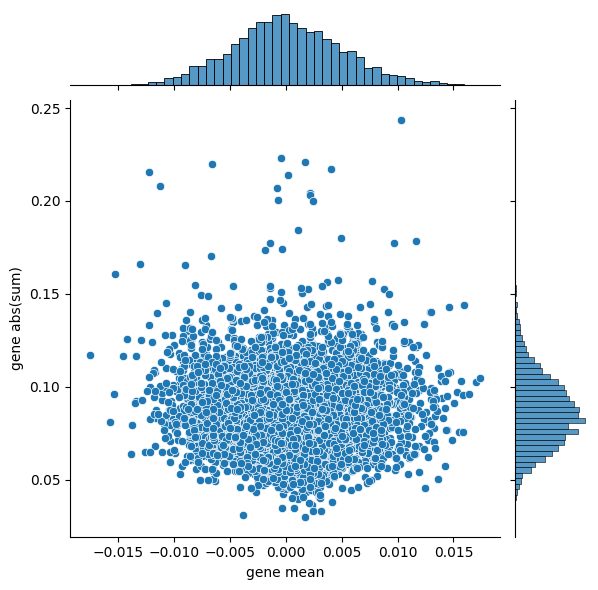

In [35]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary)

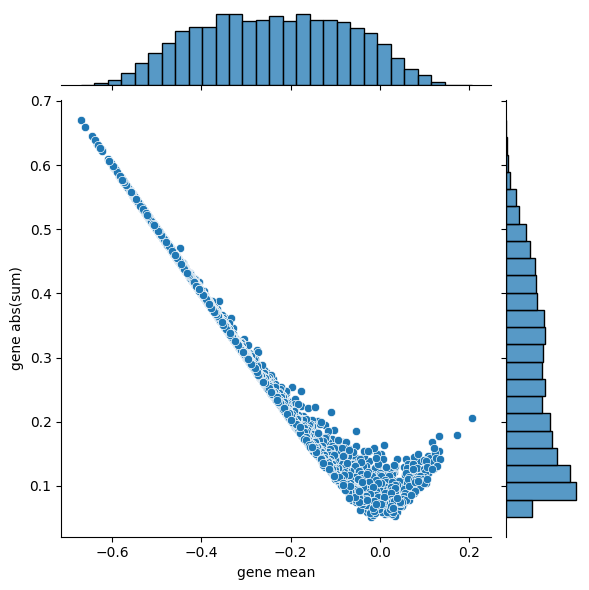

In [36]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_tcga)

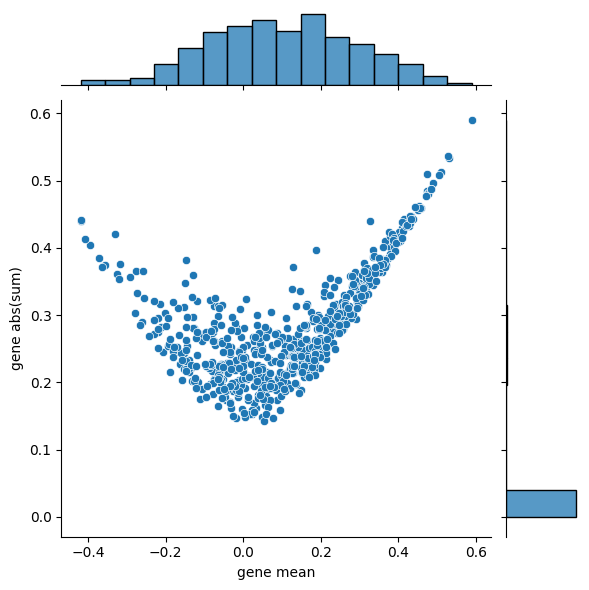

In [37]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_target)

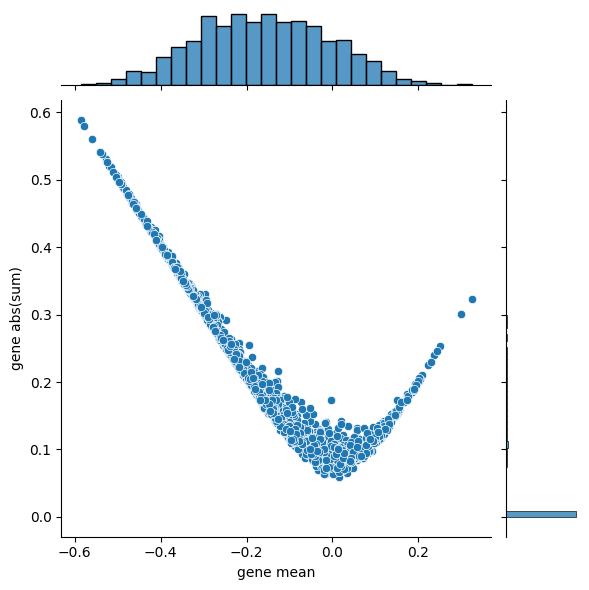

In [38]:
sns.jointplot(x = 'gene mean', y = 'gene abs(sum)',
              kind = "scatter", data = gene_summary_gtex)

Reconstruction after shuffling 

In [39]:
import random
cols = rnaseq_df_test.columns.tolist()
random.shuffle(cols)

NameError: name 'rnaseq_df_test' is not defined

In [ ]:
cols_all_index = list(range(len(cols)))
cols_all_index_100 = list(sample(cols_all_index,100))
cols_all_index_1000 = list(sample(cols_all_index,1000))
cols_all_index_5000 = list(sample(cols_all_index,5000))

In [ ]:
permute_elements_100 = [cols[i] for i in cols_all_index_100]
permute_elements_1000 = [cols[i] for i in cols_all_index_1000]
permute_elements_5000 = [cols[i] for i in cols_all_index_5000]

In [ ]:
random.shuffle(permute_elements_100)
random.shuffle(permute_elements_1000)
random.shuffle(permute_elements_5000)

In [ ]:
permuted_cols_100 = cols.copy()
permuted_cols_1000 = cols.copy()
permuted_cols_5000 = cols.copy()

In [ ]:
for i, index in enumerate(cols_all_index_100):
    permuted_cols_100[index] = permute_elements_100[i]

for i, index in enumerate(cols_all_index_1000):
    permuted_cols_1000[index] = permute_elements_1000[i]

for i, index in enumerate(cols_all_index_5000):
    permuted_cols_5000[index] = permute_elements_5000[i]

In [ ]:
rnaseq_df_shuffled_100 = pd.DataFrame(rnaseq_df_test[permuted_cols_100])
rnaseq_df_shuffled_1000 = pd.DataFrame(rnaseq_df_test[permuted_cols_1000])
rnaseq_df_shuffled_5000 = pd.DataFrame(rnaseq_df_test[permuted_cols_5000])

In [ ]:
validation_loader_shuffled_100 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_100), 
                                                         batch_size=100, shuffle=True)
validation_loader_shuffled_1000 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_1000), 
                                                         batch_size=100, shuffle=True)
validation_loader_shuffled_5000 = torch.utils.data.DataLoader(dataset=CustomDataset(rnaseq_df_shuffled_5000), 
                                                         batch_size=100, shuffle=True)

In [1]:
import numpy as np

In [2]:
np.mean([1,2,3])

2.0